# Bibliotecas

In [1]:
import numpy    as np
import pandas   as pd
import xgboost  as xgb
import seaborn  as sns

import pickle
import warnings

from matplotlib                 import pyplot       as plt

from sklearn.metrics            import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
from skopt                      import BayesSearchCV
from sklearn.model_selection    import BaseCrossValidator

warnings.filterwarnings( 'ignore' )

# Importação de dados

In [2]:
X_train = pd.read_pickle('../exports/cicle_exports/06_feature_selection/X_train.pkl', compression='gzip')
y_train = pd.read_pickle('../exports/cicle_exports/06_feature_selection/y_train.pkl', compression='gzip')

X_val = pd.read_pickle('../exports/cicle_exports/06_feature_selection/X_val.pkl', compression='gzip')
y_val = pd.read_pickle('../exports/cicle_exports/06_feature_selection/y_val.pkl', compression='gzip')

X_test = pd.read_pickle('../exports/cicle_exports/06_feature_selection/X_test.pkl', compression='gzip')
y_test = pd.read_pickle('../exports/cicle_exports/06_feature_selection/y_test.pkl', compression='gzip')

In [3]:
# Dados para utilizar na otimização:
X = pd.concat([X_train, X_val], ignore_index=True)
y = pd.concat([y_train, y_val], ignore_index=True)

In [4]:
# Convertendo para ndarray para treinamentos fora da otimização:
X_np = X.drop(['date'], axis=1).values
y_np = y.values.ravel()

X_test_np = X_test.drop(['date'], axis=1).values
y_test_np = y_test.values.ravel()

# Funções

In [5]:
def ml_error_regression( model_name:str, y_pred:np.ndarray, y:np.ndarray ):
    """
    Gera métricas de performance de um modelo de regressão.

    Parâmetros:
        model_name (str): Nome do modelo para exibição.
        y_pred (np.ndarray): Previsões da variável alvo geradas pelo modelo.
        y (np.ndarray): Variável alvo do dataset original.

    Retorna:
        pd.DataFrame: DataFrame com métricas (mae, mape, rmse).
    """
    def safe_metric(func, y_true, y_pred):
            try:
                value = func(y_true, y_pred)
                if np.isinf(value) or np.isnan(value):
                    return 'inf'
                return np.round(value, 2).astype(str)
            except (ValueError, FloatingPointError, OverflowError, ZeroDivisionError):
                return 'inf'

    score_mae     = safe_metric(mean_absolute_error, y, y_pred)
    score_mape    = safe_metric(mean_absolute_percentage_error, y, y_pred)
    score_rmse    = safe_metric(root_mean_squared_error, y, y_pred)
    score_r2      = safe_metric(r2_score, y, y_pred)

    return pd.DataFrame( {'Model Name'  : model_name, 
                          'MAE'         : score_mae, 
                          'MAPE'        : score_mape, 
                          'RMSE'        : score_rmse,
                          'R2'          : score_r2
                          }, index=[0] )

# 8.0. Otimização de hiperparâmentros

## 8.1. Bayesian Search

In [6]:
# Modelo base
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

In [7]:
# Espaço de busca dos hiperparâmetros
search_spaces = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 12),
    'eta': (0.01, 0.05),
    'learning_rate': (1e-3, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform'),
    'min_child_weight': (0.3, 0.9),
    'gamma': (1e-9, 1.0, 'log-uniform'),
    'reg_alpha': (1e-9, 10.0, 'log-uniform'),
    'reg_lambda': (1e-9, 10.0, 'log-uniform')
}

Quando os métodos de validação cruzada do scikit-lern (*StratifiedKFold, TimeSeriesSplit, GroupKFold e KFold*) não são suficientes para gerar os K-folds, é necessário criar uma função customizada:

In [8]:
class CustomCV(BaseCrossValidator):
    def __init__(self, df, n_splits=5):
        self.n_splits = n_splits
        self.df = df.copy()
        self.day_keys = self._prepare_day_keys()
        self.splits = self._generate_splits()

    def _prepare_day_keys(self):
        # Cria uma coluna (ano, mês, dia) baseados na coluna 'date'
        self.df['year_month_day'] = self.df['date'].dt.strftime('%Y-%m-%d')
        return self.df['year_month_day'].unique().tolist()

    def _generate_splits(self):
        sorted_keys = sorted(self.day_keys)
        n_total = len(sorted_keys)
        splits = []

        # Garantir que o número de divisões não é maior que o número de dias disponíveis
        if self.n_splits >= n_total:
            raise ValueError(f"n_splits ({self.n_splits}) não pode ser maior ou igual ao número total de dias únicos ({n_total})")

        # Para comportamento estilo TimeSeriesSplit
        test_size = n_total // self.n_splits
        for i in range(self.n_splits):
            test_start = i * test_size
            test_end = (i + 1) * test_size if i < self.n_splits - 1 else n_total

            test_days = sorted_keys[test_start:test_end]
            train_days = sorted_keys[:test_start]

            train_idx = self.df[self.df['year_month_day'].isin(train_days)].index.values
            test_idx = self.df[self.df['year_month_day'].isin(test_days)].index.values

            if len(train_idx) > 0 and len(test_idx) > 0:
                splits.append((train_idx, test_idx))

        return splits

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.splits)

    def split(self, X, y=None, groups=None):
        # Remove a coluna 'date' e 'year_month_day' antes de passar os dados ao modelo
        if 'date' in X.columns:
            X.drop(columns=['date'], inplace=True)
        if 'year_month_day' in X.columns:
            X.drop(columns=['year_month_day'], inplace=True)
        for train_idx, test_idx in self.splits:
            yield train_idx, test_idx


In [9]:
custom_cv = CustomCV(X, n_splits=5)

In [11]:
# Otimizador
opt = BayesSearchCV(
    estimator=model_xgb,
    search_spaces=search_spaces,
    n_iter=50,  # número de iterações da busca
    scoring='neg_mean_squared_error',  # métrica de avaliação
    cv=custom_cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [12]:
# Treinamento
opt.fit(X, y)

# Melhor modelo
print("Melhores parâmetros encontrados:")
print(opt.best_params_)

print("Melhor score (neg MSE):")
print(opt.best_score_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

In [13]:
pd.DataFrame(opt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,...,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,59.805178,3.900549,1.189356,0.550776,0.705052,0.039109,2.487780e-01,0.006057,9,0.548471,...,1.108238e-06,0.823896,"{'colsample_bytree': 0.705051979426657, 'eta':...",-0.088656,-0.106756,-0.085909,-0.088519,-0.092460,0.008326,44
1,40.020274,2.143642,0.568882,0.063804,0.918694,0.045333,5.378869e-07,0.227142,11,0.337388,...,2.276622e-03,0.976740,"{'colsample_bytree': 0.9186941777766422, 'eta'...",-0.042484,-0.054534,-0.028739,-0.029950,-0.038927,0.010496,25
2,23.400632,1.321783,0.236718,0.040397,0.722416,0.046749,8.784811e-09,0.011842,5,0.572199,...,3.744590e-04,0.986603,"{'colsample_bytree': 0.7224162561505759, 'eta'...",-0.115688,-0.135736,-0.114767,-0.116844,-0.120759,0.008678,47
3,81.567178,4.629562,1.114051,0.198821,0.906198,0.016875,2.412258e-04,0.097397,8,0.357273,...,1.316099e+00,0.693398,"{'colsample_bytree': 0.9061979941786817, 'eta'...",-0.032304,-0.052125,-0.023970,-0.026993,-0.033848,0.010966,2
4,92.294534,5.813297,1.461081,0.158766,0.899777,0.027521,5.490124e-05,0.059280,11,0.730219,...,3.394990e-06,0.829713,"{'colsample_bytree': 0.8997767208035865, 'eta'...",-0.034531,-0.051393,-0.023717,-0.028491,-0.034533,0.010461,4
5,78.694732,4.194881,1.125627,0.228616,0.867014,0.047575,2.968005e-08,0.002929,10,0.523548,...,7.125894e-02,0.778714,"{'colsample_bytree': 0.8670140089927842, 'eta'...",-0.093683,-0.111423,-0.093548,-0.097146,-0.098950,0.007344,45
6,78.245544,5.534188,1.168589,0.154139,0.808540,0.041015,1.702968e-06,0.146491,8,0.656772,...,2.181850e-02,0.817150,"{'colsample_bytree': 0.8085396792511581, 'eta'...",-0.038500,-0.050138,-0.025147,-0.028136,-0.035480,0.009807,8
7,51.625183,3.003235,0.656880,0.122980,0.771702,0.046800,2.939005e-05,0.118844,6,0.330681,...,7.199393e-06,0.912973,"{'colsample_bytree': 0.7717015338451563, 'eta'...",-0.035829,-0.055595,-0.028604,-0.032709,-0.038184,0.010373,22
8,11.856541,0.682630,0.178811,0.045344,0.977739,0.038025,6.996283e-02,0.010716,6,0.426849,...,8.785958e-04,0.587953,"{'colsample_bytree': 0.9777389931549642, 'eta'...",-0.126878,-0.145580,-0.127013,-0.129011,-0.132120,0.007817,49
9,43.465997,2.468894,0.589325,0.100251,0.501815,0.042713,4.694017e-03,0.004271,8,0.464829,...,8.677220e-01,0.906639,"{'colsample_bytree': 0.5018151536273716, 'eta'...",-0.112646,-0.131089,-0.110268,-0.111564,-0.116392,0.008527,46


## 8.2. Modelo final

In [6]:
# Definição do modelo otimizado:

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             random_state=42,
                             n_jobs=-1,
                             colsample_bytree=0.8757948791947131,
                             eta=0.05,
                             gamma=5.889036233695752e-06,
                             learning_rate=0.057668423242190424,
                             max_depth=10,
                             min_child_weight=0.9,
                             n_estimators=828,
                             reg_alpha=1e-09,
                             reg_lambda=1e-09,
                             subsample=0.7152610943510849
                             )

# Treinamento:
model_xgb.fit(X_np, y_np)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8757948791947131
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
# Performance sobre os dados de treino:

# Previsão:
y_pred_train = model_xgb.predict(X_np)

result_xgb = ml_error_regression('XGBoost - train database', 
                                np.expm1(y_pred_train),  # exp, pois a variável tinha sido transformada para escala logarítmica para seleção de variáveis 
                                np.expm1(y_np)           # exp, pois a variável tinha sido transformada para escala logarítmica para seleção de variáveis
                                )
result_xgb

,Model Name,MAE,MAPE,RMSE,R2
0,XGBoost - train database,387.13,0.06,559.47,0.97


In [8]:
# Performance sobre os dados de teste (dados não vistos):

# Previsão:
y_pred_test = model_xgb.predict(X_test_np)

# Avaliação simples:
result_xgb = ml_error_regression('XGBoost - test database', 
                                np.expm1(y_pred_test),    # exp, pois a variável tinha sido transformada para escala logarítmica para seleção de variáveis 
                                np.expm1(y_test_np)       # exp, pois a variável tinha sido transformada para escala logarítmica para seleção de variáveis
                                )
result_xgb

,Model Name,MAE,MAPE,RMSE,R2
0,XGBoost - test database,864.34,0.12,1271.03,0.83


O desempenho do **XGBoost** após a otimização foi satisfatório, portanto será o algoritmo definitivo para este estudo.

A baixa perda de performance entre as previsões sobre os dados de treino em relação aos dados de teste é indicativo de que o modelo obteve boa generalização.

## 8.3 Explicabilidade do modelo - Importância das variáveis

                  Variable  Importance
1                    promo       0.216
5                   promo2       0.172
4     competition_distance       0.121
2               store_type       0.107
3               assortment       0.105
0                    store       0.092
9          day_of_week_cos       0.044
11               month_cos       0.030
6   competition_time_month       0.029
8          day_of_week_sin       0.025
7          promo_time_week       0.023
12                 day_sin       0.013
13                 day_cos       0.013
10               month_sin       0.010


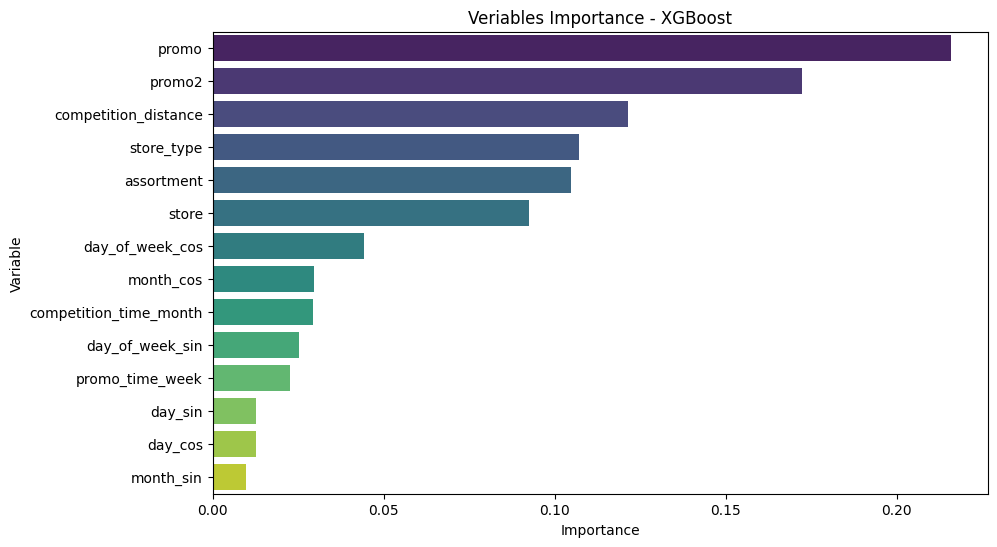

In [11]:
feature_names = X_test.drop(['date'], axis=1).columns.to_list()

# Criando um DataFrame com as Importances das features
feature_importance = pd.DataFrame({
    'Variable': feature_names,
    'Importance': model_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Exibindo o DataFrame
print(feature_importance.round(3))

# Gerando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=feature_importance, hue='Variable', palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Veriables Importance - XGBoost')
plt.show()

# Exportação de resultados

**Exportação para produto final:**

O modelo treinado é o principal componente do produto final.

In [ ]:
pickle.dump( model_xgb,     open( '../exports/cicle_products/model_xgb.pkl', 'wb' ) )
pickle.dump( y_pred_test,   open( '../exports/cicle_exports/08_fine_tuning/y_pred.pkl', 'wb' ) )